<a href="https://colab.research.google.com/github/oorucelik/github-slideshow/blob/main/MayaTelecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd

df = pd.read_excel("Churn_Data  (3).xlsx", sheet_name="churn")

# to optimize the data, one-hot encoding is necessary for categorical columns.
categorical_columns = [
    "Payment_Type",
    "Domestic_Bill_Tariff_Type",
    "Int.Bill_Tariff_Type",
    "Sex",
    "Marital Status",
    "Car_Ownership"
]
#grouped decimal columns into bins to train
bins = [18, 24, 34, 44, 54, 64, 84, 100]
labels = ["18-24", "25-34", "35-44", "45-54", "55-64", "65-84", "85+"]
df['age_groups'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
df['income_group'] = pd.qcut(df['Income'], q=5, labels=['low', 'low-mid', 'mid', 'mid-high', 'high'])
#drop grouped columns and ID
df = df.drop(columns=["Age", "Income", "Customer ID"])

# Converting MOU columns to int, improving accuracy and reducing Overfitting.
convert_dict = {'Distance_MOU': int, 'International_MOU': int, 'Local_MOU':int }
df = df.astype(convert_dict)

#applying one-hot encoding to categorical columns.
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Active users seperated for test data
df_encoded_test = df_encoded[df_encoded["Churn_Flag"] == "Active"].copy()

# Voluntary and Involuntary users seperated for train data
df_encoded_train = df_encoded[df_encoded["Churn_Flag"].isin(["Voluntary", "Involuntary"])].copy()

# Target variable: Voluntary → 1, Involuntary → 0
df_encoded_train["Target"] = (df_encoded_train["Churn_Flag"] == "Voluntary").astype(int)

#train & test data lengths
print("Train:", df_encoded_train.shape)
print("Test:", df_encoded_test.shape)

Train: (645, 16)
Test: (832, 15)


In [28]:
print(df_encoded_train.head())

   Distance_MOU  International_MOU  Local_MOU  Call_Drop  Number_of_Children  \
0             5                  7         86          0                   2   
1             0                  0         39          0                   2   
2            55                  0         93          1                   2   
4             1                 29         32          0                   2   
5             0                  0         14          0                   0   

    Churn_Flag age_groups income_group  Payment_Type_CC  Payment_Type_CH  \
0    Voluntary      55-64      low-mid            False             True   
1  Involuntary      45-54     mid-high             True            False   
2    Voluntary      65-84         high             True            False   
4    Voluntary      55-64         high             True            False   
5  Involuntary        85+          mid             True            False   

   Domestic_Bill_Tariff_Type_TariffB  Int.Bill_Tariff_Type_Sta

In [29]:
!pip install xgboost scikit-learn --quiet

In [30]:

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix

# Separate features (X) and target (y)
X = df_encoded_train.drop(columns=["Churn_Flag", "Target"])  # Exclude labels from features
y = df_encoded_train["Target"]  # 1 = Voluntary, 0 = Involuntary

# Split the data into training and internal validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the XGBoost model
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=True,
    eval_metric='logloss',
    random_state=42,
    enable_categorical=True
)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]  # Use probability estimates for AUC calculation

# Calculate performance metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_prob)

# Print evaluation results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"AUC:       {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


Accuracy:  0.9535
Precision: 0.9709
Recall:    0.9709
AUC:       0.9810

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        26
           1       0.97      0.97      0.97       103

    accuracy                           0.95       129
   macro avg       0.93      0.93      0.93       129
weighted avg       0.95      0.95      0.95       129

Confusion Matrix:
 [[ 23   3]
 [  3 100]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:54:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [31]:
# Drop columns not used in training "Churn_Flag"
X_test = df_encoded_test.drop(columns=["Churn_Flag"])

# Predict probability of voluntary churn (class = 1)
y_test_prob = model.predict_proba(X_test)[:, 1]

# Predict class: 1 = Will churn voluntarily, 0 = Will not
y_test_pred = (y_test_prob >= 0.8).astype(int)  # Optional: adjust threshold if needed

# Add prediction results to original test data
df_encoded_test["Voluntary_Prob"] = y_test_prob
df_encoded_test["Voluntary_Pred"] = y_test_pred

# Top 10 customers most likely to voluntarily churn
top_churn_risk = df_encoded_test.sort_values(by="Voluntary_Prob", ascending=False).head(10)
print(top_churn_risk[["Voluntary_Prob", "Voluntary_Pred"]])


      Voluntary_Prob  Voluntary_Pred
553         0.999598               1
729         0.999557               1
1232        0.999436               1
1467        0.999398               1
622         0.999371               1
533         0.999368               1
3           0.999331               1
1254        0.999319               1
930         0.999290               1
375         0.999288               1


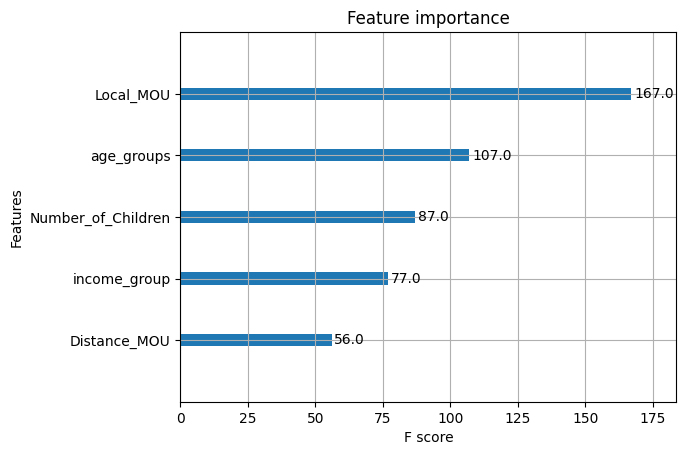

In [46]:
#explore feature importance
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=5)
plt.show()

In [34]:
#explore
df_encoded_train.groupby('Target')['Distance_MOU'].mean()
df_encoded_train.groupby('Target')['income_group'].value_counts(normalize=True)

Target  income_group
0       low-mid         0.234848
        low             0.227273
        mid             0.212121
        high            0.204545
        mid-high        0.121212
1       low             0.224172
        low-mid         0.202729
        mid-high        0.196881
        mid             0.194932
        high            0.181287
Name: proportion, dtype: float64

In [35]:
#explore
df_encoded_test.groupby('Voluntary_Pred')['Distance_MOU'].mean()
df_encoded_test.groupby('Voluntary_Pred')['age_groups'].value_counts(normalize=True)

Voluntary_Pred  age_groups
0               65-84         0.317073
                85+           0.195122
                55-64         0.146341
                35-44         0.121951
                18-24         0.097561
                25-34         0.097561
                45-54         0.024390
1               65-84         0.228824
                85+           0.158028
                35-44         0.149178
                55-64         0.142857
                25-34         0.131479
                45-54         0.113780
                18-24         0.075853
Name: proportion, dtype: float64

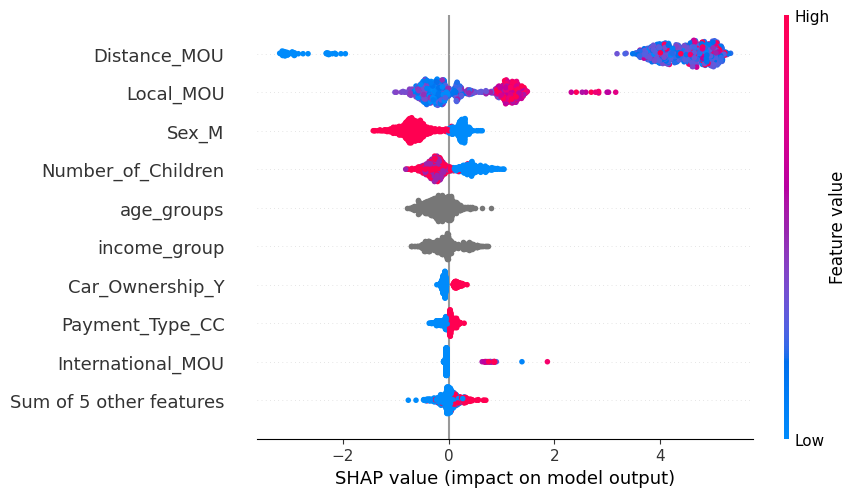

In [47]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)


In [37]:
# First, filter training data (which includes only voluntary and involuntary churn)
df_churn = df_encoded_test.copy()

# Check how voluntary churn is distributed by age group
age_churn_summary = df_churn.groupby("age_groups")["Voluntary_Pred"].agg(["count", "sum"])
age_churn_summary["Voluntary_Rate"] = age_churn_summary["sum"] / age_churn_summary["count"]
age_churn_summary.drop(columns=["sum",], inplace=True)
# Display results sorted by voluntary rate
print(age_churn_summary.sort_values(by="Voluntary_Rate", ascending=False))


            Voluntary_Rate
age_groups                
45-54             0.989011
25-34             0.962963
35-44             0.959350
55-64             0.949580
85+               0.939850
18-24             0.937500
65-84             0.932990


/tmp/ipython-input-37-2835876323.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_churn_summary = df_churn.groupby("age_groups")["Voluntary_Pred"].agg(["count", "sum"])
